In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Read in the data to a pandas DataFrame using the read_csv method.

train=pd.read_excel('Normalized_relative_quantities.xlsx')

#train

In [ ]:
#Let's plot two random columns to see the distribution
plt.clf()
sns.distplot(train['hsa-miR-1274A-002883'])
plt.title('hsa-miR-1274A-002883')
plt.show()

plt.clf()
sns.distplot(train['hsa-miR-342-3p-002260'])
plt.title('hsa-miR-342-3p-002260')
plt.show()

#Here we confirm that the miRNAs follow the "normal" negative binomial distribution for gene expression data 

In [ ]:
#Let's see again how many missing data there are / column
train.isna().sum()

In [2]:
#As we see we have 7 individuals with no prediction over if they are going to develop dm or cm ("inc_dm_2009", "inc_cv_2009"), 
#so we need to remove them from the downstream analysis 

train = train.dropna(how='any', subset=['inc_dm_2009', 'inc_cv_2009'])

#we are also going to remove sample ids labels
train = train.drop('CardID', 1)

train.shape

(553, 49)

In [3]:
#Our feature varuables (all numerical) start from the 3rd column
X = train.iloc[:,3:]

#Our target variable is the "inc_dm_2009" or "inc_cv_2009" column
y = train['inc_dm_2009']
#we can convert it to integer 
y = y.astype(int)


In [4]:
#Before any pre-processing we should split the data!

#Now split the data into training and testing before pre-processing

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#print(X_train.shape)
#print(X_test.shape)

In [5]:
y_train

280    1
293    1
378    1
557    0
194    1
      ..
72     0
281    1
9      0
365    1
196    0
Name: inc_dm_2009, Length: 442, dtype: int64

In [ ]:
#A large amount of the total data is missing in some cases, with columns missing even 80% of the data ("hsa-miR-25-000403").

#The chosen imputation methods did not work well with data that follow the negative bionomial distribution so as to impute and
#log-transform and scale later --- so I will log normalise first, impute and then scale



In [6]:
#Let's log-transform miRNA values to follow the normal distribution
X_log = np.log2(X)

X_train_log = np.log2(X_train)

X_test_log = np.log2(X_test)

In [7]:
#Imputation - It was found that for microarray missing values the weighted nearest neighbors imputation (knn imputation) 
#is a popular method - we will use it in columns missing 10% of the feature values - rest of the columns will be removed

#remove columns with missing data > 10% in the whole dataset and then impute test and train sets:
cols = X_log.columns[X_log.isnull().mean() < 0.1]

#set sets with those columns
X_train_log_flt = X_train_log[cols]
X_test_log_flt = X_test_log[cols]

#13/49 features were removed

#imputation - I will fit and transform the train set and then fit to the test set in order to simulate real testing conditions
from sklearn.impute import KNNImputer
    
imputer = KNNImputer(n_neighbors=2, weights="uniform")

X_train_imp = imputer.fit_transform(X_train_log)
X_test_imp = imputer.transform(X_test_log) #Here we only need to transform the test data

In [8]:
#Now we will scale the data to [0,1] as it is necessary for some distance-based machine learning estimators (SVM, knn) 

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

X_train_sc = scaler.fit_transform(X_train_imp)
X_test_sc = scaler.transform(X_test_imp) #Here we only need to transform the test data

In [9]:
#SVM model

#svm is independent of the dimensionality of the feature space as the appriate selection of the regularisation parameter C 
#can prevent overfitting - so feature selection is not going to be applied here

#We will do a grid search with 3 types of kernels (linear, rbf, polynomial)
from time import process_time
from sklearn.model_selection import GridSearchCV
from sklearn import svm

t0= process_time()

parameters = [{'kernel':['linear'],'C':[0.001,0.01, 0.1, 1, 10, 100, 1000]}, 
              {'kernel':['rbf'],'C':[0.001,0.01, 0.1, 1, 10, 100, 1000], 'gamma': [0.001,0.01, 0.1, 1, 10, 100, 1000]},
             {'kernel':['poly'],'C':[0.001,0.01, 0.1, 1, 10, 100, 1000], 'gamma': [0.001,0.01, 0.1, 1, 10, 100, 1000],
             'degree': [1, 2, 3, 4, 5]}]

svc = svm.SVC()
svm_model = GridSearchCV(svc, parameters, cv = 5) #(Stratified)KFold is used as cross-validation strategy by default as 
                                                  #our target feature is binary
svm_model.fit(X_train_sc, y_train)

print("The best parameters are %s with a score of %0.2f"
      % (svm_model.best_params_, svm_model.best_score_))

t1 = process_time() - t0
print("Time elapsed: ", t1) #takes 40min to run


NameError: name 'grid' is not defined

In [11]:
print("The best parameters are %s with a score of %0.2f"
      % (svm_model.best_params_, svm_model.best_score_))

t1 = process_time() - t0
print("Time elapsed: ", t1)

The best parameters are {'C': 0.001, 'kernel': 'linear'} with a score of 0.72
Time elapsed:  2485.96875


In [16]:
#predictions on the test data
prediction_svm = svm_model.score(X_test_sc, y_test)

print("Accuracy on test data: %0.2f" % prediction_svm)

Accuracy on test data: 0.71


Optimal number of features : 1


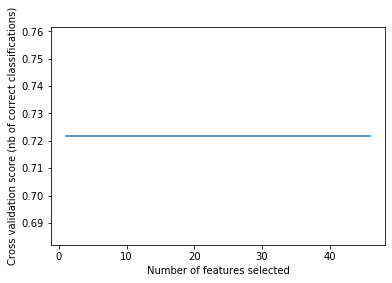

In [33]:
#Instead of reducing the feature dimensions using PCA, we will use try the recursive feature elimination in order to check
#if we could improve our model and discover which featuresare hughly ranked with the best hyperparameters

from sklearn.feature_selection import RFECV
estimator = svm.SVC(kernel='linear', C=0.001) 
svc_rfe = RFECV(estimator, step=1, cv=5)
svc_rfe.fit(X_train_sc, y_train)

print("Optimal number of features : %d" % svc_rfe.n_features_)

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(svc_rfe.grid_scores_) + 1), svc_rfe.grid_scores_)
plt.show()

In [ ]:
#We see that recursive feature elimination does not improve our score. 

In [ ]:
#Decision Trees

#Decision trees tend to overfit on data with a large number of features so first we will perform dimensionality reduction
#using pca

#The rationale is to take advantage of the Pipeline function of sklearn in order to grid search for the best number of PCA 
#components to input in our decision trees, and the best hyperparameters of our tree at the same time 

from sklearn import decomposition
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pca = decomposition.PCA()
decisiontree = DecisionTreeClassifier()

# Create a pipeline of two steps: 
# 1) tranform the data with PCA, 2) train a Decision Tree Classifier on the data.
pipe = Pipeline(steps=[('pca', pca), ('decisiontree', decisiontree)])

# Create Parameter Space

# Create a list of a sequence of integers to integrate from PCA
n_components = list(range(1,X_train_sc.shape[1]+1,1))

# Create lists of parameter for Decision Tree Classifier
criterion = ['gini', 'entropy']
max_depth = [4,6,8,12]

parameters = dict(pca__n_components=n_components,
                      decisiontree__criterion=criterion,
                      decisiontree__max_depth=max_depth)

clf = GridSearchCV(pipe, parameters, cv = 5)

clf.fit(X_train_sc, y_train)

print('Best Criterion:', clf.best_estimator_.get_params()['decisiontree__criterion'])
print('Best max_depth:', clf.best_estimator_.get_params()['decisiontree__max_depth'])
print('Best Number Of Components:', clf.best_estimator_.get_params()['pca__n_components'])
print("Best Score: %0.2f" % clf.best_score_)

#print(clf.best_estimator_.get_params()['decisiontree'])
    

In [ ]:
#predictions on the test data
prediction_clf = clf.score(X_test_sc, y_test)
print("Accuracy on test data:", prediction_clf)

In [ ]:
#Knn 

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

#define the model and parameters
knn = KNeighborsClassifier()


parameters = {'n_neighbors':[1,3,5,7,9,11,13,15,17,19,21], #usually odd numbers
              'leaf_size':[1,2,3,5],
              'weights':['uniform', 'distance']}

#Fit the model
model_knn = GridSearchCV(knn, param_grid=parameters, cv = 5)
model_knn.fit(X_train_sc,y_train)

print('Best leaf_size:', model_knn.best_estimator_.get_params()['leaf_size'])
print('Best weight function:', model_knn.best_estimator_.get_params()['weights'])
print('Best n_neighbors:', model_knn.best_estimator_.get_params()['n_neighbors'])
print('Best Score:', model_knn.best_score_)

In [ ]:
#predictions on the test data
prediction_knn = model_knn.score(X_test_sc, y_test)
print("Accuracy on test data:", prediction_knn)

In [ ]:
#maybe repeat knn with pca

In [31]:
#Random Forests
#Let's tune the hyperparameters

#Here we will try a different approach - we will use randomize grid at first to limit our search space and then we will use
# a more exhaustive approach

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestClassifier()

# Number of trees in random forest
n_estimators = [200, 500, 1000, 1500, 2500]
# Number of features to consider at every split
max_features = ['auto', 'log2']
# Maximum number of levels in tree
max_depth = [10, 20, 30, 40, 50]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 20]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_random = RandomizedSearchCV(
    estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, n_jobs = -1)

rf_random.fit(X_train_sc, y_train)

print("Best Score:", rf_random.best_params_)
print("Best Score: %0.2f" % rf_random.best_score_)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [40]:
#Random Forests 2
#Let's see if we can improve the score by grinding search around the best parameters

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

#define the model and parameters
rf_v2 = RandomForestClassifier()

n_estimators = [300, 500, 800, 1000]
max_features = ['auto']
max_depth = [30, 40, 50, 60]
min_samples_split = [10, 15, 20, 25]
min_samples_leaf = [6, 8, 10, 12]
bootstrap = [True]

parameters = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

#Fit the model
model_rf_v2 = GridSearchCV(rf_v2, param_grid=parameters, cv = 5)
model_rf_v2.fit(X_train_sc,y_train)

print("Best Score:", model_rf_v2.best_params_)
print("Best Score: %0.2f" % model_rf_v2.best_score_)

Best Score: {'bootstrap': True, 'max_depth': 50, 'max_features': 'auto', 'min_samples_leaf': 8, 'min_samples_split': 10, 'n_estimators': 300}
Best Score: 0.73


In [41]:
#The score did not change whatsoever

Best Score: {'bootstrap': True, 'max_depth': 50, 'max_features': 'auto', 'min_samples_leaf': 8, 'min_samples_split': 10, 'n_estimators': 300}
Best Score: 0.73


In [ ]:
#Logistic regression



In [ ]:
#We will try:
#SVM
#General discriminant analysis
#Decision Trees
#Random Forest
#GLMs (generalized linear models) -- logistic regression tried in paper
#Ensembl of methods
#linear model elastic net

#do feature selection 


In [ ]:
#feature selection before SVM (PCA?)